# Predict Salary
## Steps performed:
* Label-encoding
* Scaling
* GridSearch with CV=10
* fit AdaBoostRegressor, RF, SVR, Lasso, ElasticNet
* Predict using MSE loss function

In [1]:
import pandas as pd
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import Lasso,ElasticNet
import numpy as np

In [2]:
trainFeatures = pd.read_csv("./train_features.csv",index_col="jobId")
trainSalaries = pd.read_csv("./train_salaries.csv",index_col="jobId")
trainFinal = trainFeatures.join(trainSalaries)
testFeatures = pd.read_csv("./test_features.csv", index_col="jobId")


## Lets explore the train data

116.06137563810069


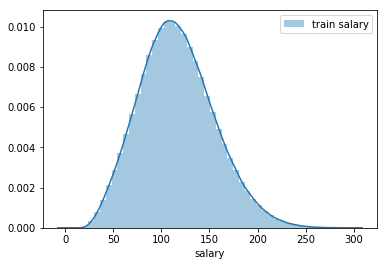

In [5]:
plt.figure()
sb.distplot(trainFinal['salary'], label='train salary')
plt.legend()
print(trainFinal['salary'].mean(axis=0))

In [8]:
trainFinal.groupby(['industry']).first()

,companyId,jobType,degree,major,yearsExperience,milesFromMetropolis,salary
industry,,,,,,,
AUTO,COMP38,MANAGER,DOCTORAL,CHEMISTRY,8,17,142
EDUCATION,COMP24,JUNIOR,BACHELORS,CHEMISTRY,9,70,73
FINANCE,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,8,16,163
HEALTH,COMP37,CFO,MASTERS,MATH,10,83,130
OIL,COMP4,JUNIOR,NONE,NONE,8,29,79
SERVICE,COMP20,CTO,MASTERS,BIOLOGY,13,8,172
WEB,COMP19,CEO,HIGH_SCHOOL,NONE,3,73,101


In [9]:
trainFinal.groupby(['jobType']).first()

,companyId,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobType,,,,,,,
CEO,COMP19,HIGH_SCHOOL,NONE,WEB,3,73,101
CFO,COMP37,MASTERS,MATH,HEALTH,10,83,130
CTO,COMP20,MASTERS,BIOLOGY,SERVICE,13,8,172
JANITOR,COMP20,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
JUNIOR,COMP24,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
MANAGER,COMP38,DOCTORAL,CHEMISTRY,AUTO,8,17,142
SENIOR,COMP31,DOCTORAL,BUSINESS,EDUCATION,1,9,82
VICE_PRESIDENT,COMP52,DOCTORAL,PHYSICS,HEALTH,10,38,137


In [10]:
trainFinal.groupby(['degree']).first() # degree none?

,companyId,jobType,major,industry,yearsExperience,milesFromMetropolis,salary
degree,,,,,,,
BACHELORS,COMP7,VICE_PRESIDENT,PHYSICS,FINANCE,8,16,163
DOCTORAL,COMP52,VICE_PRESIDENT,PHYSICS,HEALTH,10,38,137
HIGH_SCHOOL,COMP19,CEO,NONE,WEB,3,73,101
MASTERS,COMP37,CFO,MATH,HEALTH,10,83,130
NONE,COMP15,CFO,NONE,HEALTH,23,24,178


In [11]:
trainFinal.groupby(['major']).first()

,companyId,jobType,degree,industry,yearsExperience,milesFromMetropolis,salary
major,,,,,,,
BIOLOGY,COMP20,CTO,MASTERS,SERVICE,13,8,172
BUSINESS,COMP34,CTO,MASTERS,AUTO,9,6,130
CHEMISTRY,COMP38,MANAGER,DOCTORAL,AUTO,8,17,142
COMPSCI,COMP15,MANAGER,DOCTORAL,FINANCE,2,31,113
ENGINEERING,COMP30,MANAGER,DOCTORAL,WEB,22,14,206
LITERATURE,COMP61,VICE_PRESIDENT,MASTERS,SERVICE,23,43,126
MATH,COMP37,CFO,MASTERS,HEALTH,10,83,130
NONE,COMP19,CEO,HIGH_SCHOOL,WEB,3,73,101
PHYSICS,COMP52,VICE_PRESIDENT,DOCTORAL,HEALTH,10,38,137


## Convert Categorical data to numerical for regression using Label Encoder

In [3]:
train_catX = trainFinal.select_dtypes(include=[object])
train_catX.head(3)

,companyId,jobType,degree,major,industry
jobId,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH


In [4]:
le = preprocessing.LabelEncoder()
train_catX2 = train_catX.apply(le.fit_transform)
train_catX2.head(3)

,companyId,jobType,degree,major,industry
jobId,,,,,
JOB1362684407687,31,1,3,6,3
JOB1362684407688,11,0,2,7,6
JOB1362684407689,48,7,1,8,3


In [47]:
train_catX2.groupby(['industry']).first() 

,companyId,jobType,degree,major
industry,,,,
0,32,5,1,2
1,17,4,0,2
2,60,7,0,8
3,31,1,3,6
4,34,4,4,7
5,13,2,3,0
6,11,0,2,7


In [51]:
train = train_catX2.join(trainFinal[trainFinal.columns[5:8]],how='outer')
print(train[train.columns[0:7]].head(2))
#Normalize data
Y = train[train.columns[7]].values
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(train[train.columns[0:7]])
X = scaled_values

                  companyId  jobType  degree  major  industry  \
jobId                                                           
JOB1362684407687         31        1       3      6         3   
JOB1362684407688         11        0       2      7         6   

                  yearsExperience  milesFromMetropolis  
jobId                                                   
JOB1362684407687               10                   83  
JOB1362684407688                3                   73  


## Fit regressive models
* AdaBoost regressor => MSE: 637 
* RandomForest regressor=> MSE: 60
* SVR=> Not converging
* Lasso => MSE: 900+
* ElasticNet=> MSE: 750+

In [43]:
# AdaBoost regressor
param_dist = {
 'n_estimators': [50,100,150],
 'learning_rate' : [1,.1,.5],
 'loss':['linear']   
 }

clf = GridSearchCV(AdaBoostRegressor(),
 param_grid = param_dist,
 cv=10, verbose=10,n_jobs=4)
clf.fit(X, Y)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................
[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.4852326585602221, total= 2.3min
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................
[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.5160300551738868, total= 2.3min
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................
[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.5126759816465585, total= 2.3min
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................
[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.512584003660228, total= 2.3min
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  5.2min


[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.5218863235024848, total= 2.5min
[CV] learning_rate=1, loss=linear, n_estimators=50 ...................
[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.5036375612876753, total= 2.5min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.5216263661063425, total= 2.5min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.5189036622433093, total= 2.5min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=50, score=0.5811540274394497, total= 2.7min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  8.0min


[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.4681012589223673, total= 4.4min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.47444143629499236, total= 4.4min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.472845044359678, total= 4.5min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.4747197494785135, total= 4.4min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.4745997064019238, total= 4.8min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.49166211778910557, total= 4.8min
[CV] learning_rate=1, loss=linear, n_estimators=100 ..................
[CV]  lea

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 19.1min


[CV] learning_rate=1, loss=linear, n_estimators=150 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.4725346943374594, total= 5.5min
[CV] learning_rate=1, loss=linear, n_estimators=150 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.4837811074304132, total= 6.2min
[CV] learning_rate=1, loss=linear, n_estimators=150 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=100, score=0.5543265722357991, total= 6.8min
[CV] learning_rate=1, loss=linear, n_estimators=150 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=150, score=0.4955452120407495, total= 5.1min
[CV] learning_rate=1, loss=linear, n_estimators=150 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=150, score=0.449467527683745, total= 6.8min
[CV] learning_rate=1, loss=linear, n_estimators=150 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=150, score=0.45118226382038956, total= 6.7min
[CV] learn

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 29.9min


[CV]  learning_rate=1, loss=linear, n_estimators=150, score=0.47612300043688605, total= 6.5min
[CV] learning_rate=1, loss=linear, n_estimators=150 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=150, score=0.45930054601651377, total= 6.4min
[CV] learning_rate=1, loss=linear, n_estimators=150 ..................
[CV]  learning_rate=1, loss=linear, n_estimators=150, score=0.4708274155997098, total= 4.8min
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV]  learning_rate=1, loss=linear, n_estimators=150, score=0.4603027458427222, total= 6.0min
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=50, score=0.5337704402258421, total= 2.6min
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV]  learning_rate=1, loss=linear, n_estimators=150, score=0.5557287898399803, total= 6.7min
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV]  l

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 40.3min


[CV]  learning_rate=0.1, loss=linear, n_estimators=50, score=0.5312330986946487, total= 2.6min
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=50, score=0.5333164779470564, total= 2.6min
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=50, score=0.5368208668032078, total= 2.5min
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=50, score=0.5346412271881626, total= 2.5min
[CV] learning_rate=0.1, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=50, score=0.5374765705254555, total= 2.5min
[CV] learning_rate=0.1, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=50, score=0.5365275699745464, total= 2.5min
[CV] learning_rate=0.1, loss=linear, n_estimators=100 ................
[CV]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 49.8min


[CV]  learning_rate=0.1, loss=linear, n_estimators=100, score=0.5685762894768518, total= 5.0min
[CV] learning_rate=0.1, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=100, score=0.5682538711235796, total= 5.0min
[CV] learning_rate=0.1, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=100, score=0.5655612404573058, total= 5.1min
[CV] learning_rate=0.1, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=100, score=0.5667227543183522, total= 5.2min
[CV] learning_rate=0.1, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=100, score=0.5646116819179072, total= 5.2min
[CV] learning_rate=0.1, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=100, score=0.5698610952508094, total= 5.2min
[CV] learning_rate=0.1, loss=linear, n_estimators=150 ...............

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 67.6min


[CV]  learning_rate=0.1, loss=linear, n_estimators=150, score=0.5716478743356607, total= 7.8min
[CV] learning_rate=0.1, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=150, score=0.5706685504095059, total= 7.9min
[CV] learning_rate=0.1, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=150, score=0.5729049143399925, total= 7.9min
[CV] learning_rate=0.1, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.1, loss=linear, n_estimators=150, score=0.569075815055329, total= 8.1min
[CV] learning_rate=0.5, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=150, score=0.5733736131975469, total= 8.1min
[CV] learning_rate=0.5, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=linear, n_estimators=50, score=0.5527334710387899, total= 2.5min
[CV] learning_rate=0.5, loss=linear, n_estimators=50 .................


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 83.2min


[CV]  learning_rate=0.5, loss=linear, n_estimators=50, score=0.556994848689671, total= 2.5min
[CV] learning_rate=0.5, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=linear, n_estimators=50, score=0.5597961672389418, total= 2.5min
[CV] learning_rate=0.5, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=linear, n_estimators=50, score=0.5575171186771646, total= 2.5min
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=50, score=0.5555226853982472, total= 2.5min
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=50, score=0.5880012594476699, total= 2.5min
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=50, score=0.5506440733932841, total= 2.5min
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV] 

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 96.5min


[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.5255270726761194, total= 4.7min
[CV] learning_rate=0.5, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.5789169349868407, total= 5.0min
[CV] learning_rate=0.5, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.521772028859443, total= 4.7min
[CV] learning_rate=0.5, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=150, score=0.49299619670077194, total= 6.7min
[CV] learning_rate=0.5, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=150, score=0.5074231540398612, total= 6.7min
[CV] learning_rate=0.5, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=150, score=0.5019568318123044, total= 6.7min
[CV] learning_rate=0.5, loss=linear, n_estimators=150 ...............

[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed: 118.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [50, 100, 150], 'learning_rate': [1, 0.1, 0.5], 'loss': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [44]:
clf.best_params_

{'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 150}

In [56]:
# RF regressor
param_dist = {
 'n_estimators': [10,20,50]
 }
clf1 = GridSearchCV(RandomForestRegressor(),
 param_grid = param_dist,
 cv=10, verbose=10,n_jobs=4)
clf1.fit(X, Y)
clf1.best_params_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=50, score=0.7238660155804211, total= 6.9min
[CV] ........ n_estimators=50, score=0.7232126459131555, total= 6.9min
[CV] ........ n_estimators=50, score=0.7239347809536338, total= 6.9min
[CV] ......... n_estimators=50, score=0.722981039439651, total= 6.9min
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=50, score=0.7241117598875488, total= 6.5min
[CV] ........ n_

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed: 16.4min remaining: 16.4min
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed: 16.4min remaining:  7.0min


[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=50, score=0.7243270566444809, total= 3.9min
[CV] ........ n_estimators=50, score=0.7247162318370777, total= 3.9min


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 21.1min finished


{'n_estimators': 50}

In [ ]:
# SVR
param_dist = {
  'C': [1,2,16,64,1024],
  'kernel' : ['rbf','linear']
 }

clf2 = GridSearchCV(estimator=SVR(), param_grid = param_dist,
 cv=3, verbose=10,n_jobs=4)
clf2.fit(X,Y)
clf2.best_params_

In [22]:
# Lasso
alphas = np.logspace(-8, 1)
clf3 = GridSearchCV(estimator=Lasso(),
param_grid=dict(alpha=alphas), cv=10, scoring='r2',verbose=10)
clf3.fit(X,Y)
clf3.best_params_

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] alpha=1e-08 .....................................................
[CV] ............ alpha=1e-08, score=0.3836499275578865, total=   0.6s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ............ alpha=1e-08, score=0.3821751482178679, total=   0.3s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ............ alpha=1e-08, score=0.3814041240020486, total=   0.3s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV] ............ alpha=1e-08, score=0.3859540993802548, total=   0.3s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


[CV] ........... alpha=1e-08, score=0.38033450603503627, total=   0.3s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s


[CV] ............. alpha=1e-08, score=0.383773498923511, total=   0.3s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.3s remaining:    0.0s


[CV] ........... alpha=1e-08, score=0.37920787211098284, total=   0.3s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.7s remaining:    0.0s


[CV] ............ alpha=1e-08, score=0.3820343972201412, total=   0.4s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.1s remaining:    0.0s


[CV] ............ alpha=1e-08, score=0.3876629356120388, total=   0.3s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.4s remaining:    0.0s


[CV] ........... alpha=1e-08, score=0.38196371212609914, total=   0.5s
[CV] alpha=1.52641796718e-08 .........................................
[CV]  alpha=1.52641796718e-08, score=0.3836499275589076, total=   0.5s
[CV] alpha=1.52641796718e-08 .........................................
[CV]  alpha=1.52641796718e-08, score=0.3821751482232796, total=   0.4s
[CV] alpha=1.52641796718e-08 .........................................
[CV]  alpha=1.52641796718e-08, score=0.3814041239992574, total=   0.3s
[CV] alpha=1.52641796718e-08 .........................................
[CV]  alpha=1.52641796718e-08, score=0.38595409937504976, total=   0.3s
[CV] alpha=1.52641796718e-08 .........................................
[CV]  alpha=1.52641796718e-08, score=0.3803345060401472, total=   0.4s
[CV] alpha=1.52641796718e-08 .........................................
[CV]  alpha=1.52641796718e-08, score=0.3837734989148722, total=   0.5s
[CV] alpha=1.52641796718e-08 .........................................
[CV] 

[CV]  alpha=1.26485521686e-07, score=0.38203439730673605, total=   0.4s
[CV] alpha=1.26485521686e-07 .........................................
[CV]  alpha=1.26485521686e-07, score=0.38766293545755803, total=   0.3s
[CV] alpha=1.26485521686e-07 .........................................
[CV]  alpha=1.26485521686e-07, score=0.38196371232505066, total=   0.4s
[CV] alpha=1.93069772888e-07 .........................................
[CV]  alpha=1.93069772888e-07, score=0.3836499276404375, total=   0.5s
[CV] alpha=1.93069772888e-07 .........................................
[CV]  alpha=1.93069772888e-07, score=0.3821751483444332, total=   0.4s
[CV] alpha=1.93069772888e-07 .........................................
[CV]  alpha=1.93069772888e-07, score=0.38140412391346534, total=   0.3s
[CV] alpha=1.93069772888e-07 .........................................
[CV]  alpha=1.93069772888e-07, score=0.3859540992228436, total=   0.3s
[CV] alpha=1.93069772888e-07 .........................................
[C

[CV]  alpha=1.59985871961e-06, score=0.38377349592038834, total=   0.3s
[CV] alpha=1.59985871961e-06 .........................................
[CV]  alpha=1.59985871961e-06, score=0.37920787187037974, total=   0.3s
[CV] alpha=1.59985871961e-06 .........................................
[CV]  alpha=1.59985871961e-06, score=0.3820343986545216, total=   0.3s
[CV] alpha=1.59985871961e-06 .........................................
[CV]  alpha=1.59985871961e-06, score=0.38766293363322335, total=   0.3s
[CV] alpha=1.59985871961e-06 .........................................
[CV]  alpha=1.59985871961e-06, score=0.3819637145303356, total=   0.3s
[CV] alpha=2.44205309455e-06 .........................................
[CV]  alpha=2.44205309455e-06, score=0.38364992842155177, total=   0.3s
[CV] alpha=2.44205309455e-06 .........................................
[CV]  alpha=2.44205309455e-06, score=0.3821751502040066, total=   0.3s
[CV] alpha=2.44205309455e-06 .........................................
[C

[CV]  alpha=2.02358964773e-05, score=0.38595408082456795, total=   0.4s
[CV] alpha=2.02358964773e-05 .........................................
[CV]  alpha=2.02358964773e-05, score=0.3803345267789042, total=   0.3s
[CV] alpha=2.02358964773e-05 .........................................
[CV]  alpha=2.02358964773e-05, score=0.3837734627873206, total=   0.3s
[CV] alpha=2.02358964773e-05 .........................................
[CV]  alpha=2.02358964773e-05, score=0.3792078679169115, total=   0.3s
[CV] alpha=2.02358964773e-05 .........................................
[CV]  alpha=2.02358964773e-05, score=0.38203441753814527, total=   0.3s
[CV] alpha=2.02358964773e-05 .........................................
[CV]  alpha=2.02358964773e-05, score=0.38766291149156673, total=   0.3s
[CV] alpha=2.02358964773e-05 .........................................
[CV] . alpha=2.02358964773e-05, score=0.381963740125038, total=   0.3s
[CV] alpha=3.08884359648e-05 .........................................
[CV

[CV] . alpha=0.00025595479227, score=0.3821753803006446, total=   0.3s
[CV] alpha=0.00025595479227 ..........................................
[CV] . alpha=0.00025595479227, score=0.3814039893159934, total=   0.3s
[CV] alpha=0.00025595479227 ..........................................
[CV]  alpha=0.00025595479227, score=0.38595385416415007, total=   0.3s
[CV] alpha=0.00025595479227 ..........................................
[CV] . alpha=0.00025595479227, score=0.3803347599073411, total=   0.4s
[CV] alpha=0.00025595479227 ..........................................
[CV] . alpha=0.00025595479227, score=0.3837730546352741, total=   0.3s
[CV] alpha=0.00025595479227 ..........................................
[CV] . alpha=0.00025595479227, score=0.3792078080037872, total=   0.4s
[CV] alpha=0.00025595479227 ..........................................
[CV] ... alpha=0.00025595479227, score=0.38203466734798, total=   0.3s
[CV] alpha=0.00025595479227 ..........................................
[CV] .

[CV] . alpha=0.00212095088792, score=0.3819660920389928, total=   0.4s
[CV] alpha=0.00323745754282 ..........................................
[CV] .. alpha=0.00323745754282, score=0.383650102251859, total=   0.2s
[CV] alpha=0.00323745754282 ..........................................
[CV] . alpha=0.00323745754282, score=0.3821779777738685, total=   0.3s
[CV] alpha=0.00323745754282 ..........................................
[CV] . alpha=0.00323745754282, score=0.3814019408529604, total=   0.3s
[CV] alpha=0.00323745754282 ..........................................
[CV] . alpha=0.00323745754282, score=0.3859504395859793, total=   0.3s
[CV] alpha=0.00323745754282 ..........................................
[CV]  alpha=0.00323745754282, score=0.38033718333776556, total=   0.2s
[CV] alpha=0.00323745754282 ..........................................
[CV]  alpha=0.00323745754282, score=0.38376770014491934, total=   0.3s
[CV] alpha=0.00323745754282 ..........................................
[CV]  

[CV] . alpha=0.0268269579528, score=0.38203226367189735, total=   0.3s
[CV] alpha=0.0268269579528 ...........................................
[CV] . alpha=0.0268269579528, score=0.38761735282121523, total=   0.3s
[CV] alpha=0.0268269579528 ...........................................
[CV] . alpha=0.0268269579528, score=0.38196217283953615, total=   0.2s
[CV] alpha=0.0409491506238 ...........................................
[CV] . alpha=0.0409491506238, score=0.38361328797117866, total=   0.2s
[CV] alpha=0.0409491506238 ...........................................
[CV] .. alpha=0.0409491506238, score=0.3821388803796485, total=   0.3s
[CV] alpha=0.0409491506238 ...........................................
[CV] . alpha=0.0409491506238, score=0.38133246381503294, total=   0.2s
[CV] alpha=0.0409491506238 ...........................................
[CV] . alpha=0.0409491506238, score=0.38583598345286785, total=   0.2s
[CV] alpha=0.0409491506238 ...........................................
[CV] .

[CV] ... alpha=0.33932217719, score=0.37885824789946376, total=   0.3s
[CV] alpha=0.33932217719 .............................................
[CV] .... alpha=0.33932217719, score=0.3751382885951493, total=   0.3s
[CV] alpha=0.33932217719 .............................................
[CV] .... alpha=0.33932217719, score=0.3779825347729182, total=   0.3s
[CV] alpha=0.33932217719 .............................................
[CV] .... alpha=0.33932217719, score=0.3832346503871935, total=   0.3s
[CV] alpha=0.33932217719 .............................................
[CV] ... alpha=0.33932217719, score=0.37786912436407016, total=   0.3s
[CV] alpha=0.517947467923 ............................................
[CV] ... alpha=0.517947467923, score=0.3740153170296052, total=   0.3s
[CV] alpha=0.517947467923 ............................................
[CV] ... alpha=0.517947467923, score=0.3724298717909931, total=   0.3s
[CV] alpha=0.517947467923 ............................................
[CV] .

[CV] .. alpha=4.29193426013, score=0.004340722837742006, total=   0.2s
[CV] alpha=4.29193426013 .............................................
[CV] .. alpha=4.29193426013, score=0.004790918494433916, total=   0.2s
[CV] alpha=4.29193426013 .............................................
[CV] .... alpha=4.29193426013, score=0.0045442844410295, total=   0.2s
[CV] alpha=4.29193426013 .............................................
[CV] . alpha=4.29193426013, score=0.0052555946376151574, total=   0.2s
[CV] alpha=4.29193426013 .............................................
[CV] .. alpha=4.29193426013, score=0.004198274045344119, total=   0.2s
[CV] alpha=4.29193426013 .............................................
[CV] .. alpha=4.29193426013, score=0.004054784312507942, total=   0.2s
[CV] alpha=4.29193426013 .............................................
[CV] .. alpha=4.29193426013, score=0.004791730159352969, total=   0.2s
[CV] alpha=6.5512855686 ..............................................
[CV]  

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.9min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-08,   1.52642e-08,   2.32995e-08,   3.55648e-08,
         5.42868e-08,   8.28643e-08,   1.26486e-07,   1.93070e-07,
         2.94705e-07,   4.49843e-07,   6.86649e-07,   1.04811e-06,
         1.59986e-06,   2.44205e-06,   3.72759e-06,   5.68987e-06,
         8....    1.20679e+00,   1.84207e+00,   2.81177e+00,   4.29193e+00,
         6.55129e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=10)

In [ ]:
# Elastic net
param_dist = {
  'alpha': [-1,0,1],
  'l1_ratio' : [0,1]
 }
clf4 = GridSearchCV(estimator=ElasticNet(),
param_grid=param_dist,cv=10, verbose=10)
clf4.fit(X,Y)
clf4.best_params_

# Lets Predict

In [57]:
# Predict- 
Y_pred = clf1.predict(X)
print(mean_squared_error(Y, Y_pred))
print(Y_pred,Y)

60.9011436665
[ 127.24  103.32  140.22 ...,   61.78  143.16  101.36] [130 101 137 ...,  64 149  88]


### Scale test features

In [60]:
test_catX = testFeatures.select_dtypes(include=[object])
test_catX.head(3)
test_catX = test_catX.dropna()

In [61]:
test_catX2 = test_catX.apply(le.fit_transform)
test_catX2.head(3)

,companyId,jobType,degree,major,industry
jobId,,,,,
JOB1362685407687,27,6,3,8,4
JOB1362685407688,5,5,5,8,1
JOB1362685407689,2,3,4,1,4


In [64]:
test = test_catX2.join(testFeatures[testFeatures.columns[5:]],how='outer')
# #Normalize data
test = test.dropna()
scaled_values = scaler.fit_transform(test)
testX = scaled_values

In [65]:
# Predict- 
Y_testpred = clf.predict(testX)

In [66]:
print(pd.Series(Y_testpred))

0          138.159854
1          112.063968
2          109.882836
3          123.430959
4          103.653829
5          114.485614
6          107.177382
7          113.158699
8          138.159854
9          100.324604
10         110.975339
11          96.072579
12         118.385236
13         103.119999
14          84.594422
15         127.478410
16         108.034358
17         101.063892
18          96.475928
19         159.937105
20          87.258123
21          89.281058
22          90.517577
23          96.767398
24         135.306772
25         115.282867
26          99.203633
27         131.709439
28         122.679160
29         131.868402
              ...    
999971     141.135710
999972     108.124323
999973      77.557777
999974     120.161073
999975      98.260035
999976     126.320998
999977     148.073456
999978     156.068164
999979     132.876833
999980      77.557777
999981     141.494384
999982     135.606466
999983     113.238398
999984      80.825957
999985    